# ***Sales Forecasting with Time Series***

In [1]:
import pandas as pd

df = pd.read_csv("train.csv")
df.head()


,date,store,item,sales
0,2013-01-01,1,1.0,13.0
1,2013-01-02,1,1.0,11.0
2,2013-01-03,1,1.0,14.0
3,2013-01-04,1,1.0,13.0
4,2013-01-05,1,1.0,10.0


Convert date column to actual datetime type

In [2]:
df['date'] = pd.to_datetime(df['date'])


Convert daily data → monthly data

In [3]:
monthly_df = df.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()
monthly_df.head()


/tmp/ipython-input-427074634.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()


,date,store,item,sales
0,2013-01-31,46500,121520.0,259225.0
1,2013-02-28,42000,109760.0,262743.0
2,2013-03-31,46500,121520.0,352169.0
3,2013-04-30,45000,117600.0,388869.0
4,2013-05-31,46500,121520.0,434861.0


pd.Grouper() groups the dates by Month (freq='M')

.sum() adds all sales values inside the month

result = each row represents one month + total sales of that month

# **rename columns to Prophet style**
ds = date

y = value we want to forecast

In [4]:
monthly_df = monthly_df[['date','sales']]
monthly_df.columns = ['ds','y']
monthly_df.head()


,ds,y
0,2013-01-31,259225.0
1,2013-02-28,262743.0
2,2013-03-31,352169.0
3,2013-04-30,388869.0
4,2013-05-31,434861.0


# **Build the Forecasting Model**

import ARIMA model

In [11]:
from statsmodels.tsa.arima.model import ARIMA


Train the model

In [12]:
model = ARIMA(monthly_df['y'], order=(5,1,0))
model_fit = model.fit()



order=(5,1,0) means:

5 = AR term (past lag influence)

1 = differencing to remove trend

0 = MA term not used here

this is a common simple configuration that works well for clean retail data.

forecast next 12 months

In [13]:
forecast_values = model_fit.forecast(steps=12)
forecast_values


,predicted_mean
60,380952.788459
61,385836.013997
62,421296.767998
63,383358.047966
64,430395.985964
65,446686.289877
66,466623.365089
67,439308.333248
68,461957.307777
69,448265.846015


build a dataframe with dates + forecast values

In [14]:
future_dates = pd.date_range(monthly_df['ds'].iloc[-1] + pd.offsets.MonthEnd(), periods=12, freq='M')
forecast_df = pd.DataFrame({'ds': future_dates, 'yhat': forecast_values})
forecast_df.head()


/tmp/ipython-input-1336304001.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(monthly_df['ds'].iloc[-1] + pd.offsets.MonthEnd(), periods=12, freq='M')


,ds,yhat
60,2018-01-31,380952.788459
61,2018-02-28,385836.013997
62,2018-03-31,421296.767998
63,2018-04-30,383358.047966
64,2018-05-31,430395.985964


we create new monthly dates for the 12 future months
and combine them with predicted numbers

combine actual + forecast for exporting to Power BI

In [15]:
combined_df = pd.concat([monthly_df[['ds','y']], forecast_df], ignore_index=True)
combined_df.to_csv("forecast_export.csv", index=False)


**VISUALIZATION**

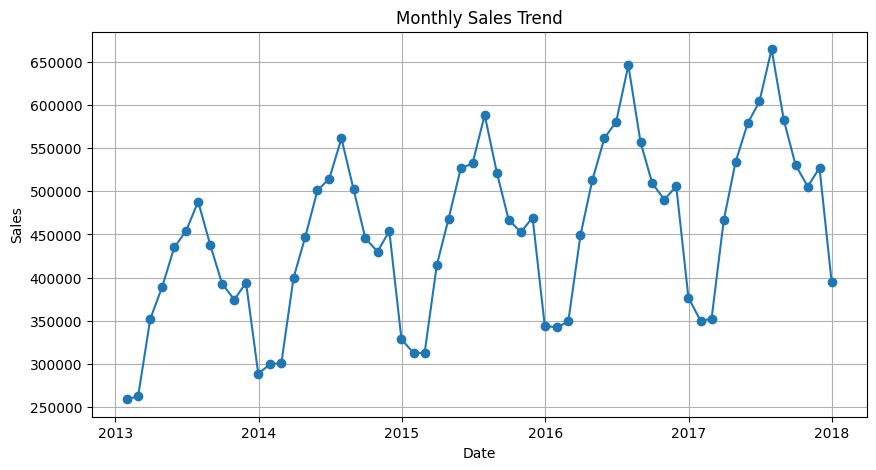

In [17]:
import matplotlib.pyplot as plt

# Q1 — Monthly Sales Trend Line Chart

plt.figure(figsize=(10,5))
plt.plot(monthly_df['ds'], monthly_df['y'], marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

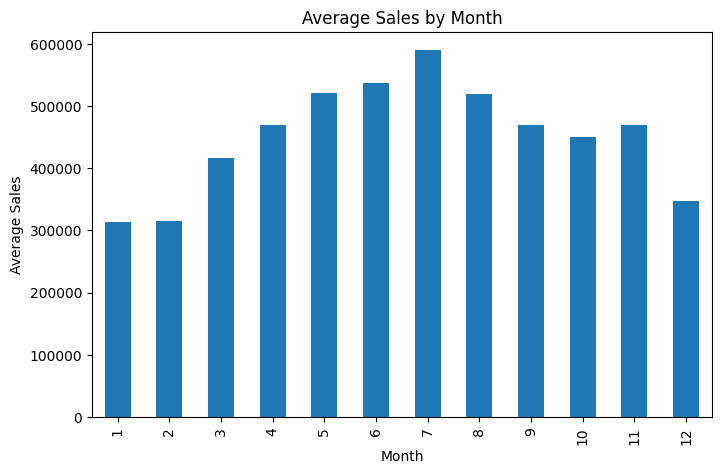

In [18]:
# create month column
monthly_df['month'] = monthly_df['ds'].dt.month

# calculate average by month
monthly_avg = monthly_df.groupby('month')['y'].mean()

# bar chart
plt.figure(figsize=(8,5))
monthly_avg.plot(kind='bar')
plt.title("Average Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()


Total forecasted sales for next 12 months

In [19]:
forecast_total = forecast_df['yhat'].sum()
forecast_total


np.float64(5136909.497792983)

This number helps estimate the expected next-year revenue demand.

**Compare last actual year vs forecast next year**

In [20]:
# last actual 12 months sum
last_actual = monthly_df['y'].tail(12).sum()

# next 12 months forecast sum
next_forecast = forecast_df['yhat'].sum()

growth_percent = ((next_forecast - last_actual) / last_actual) * 100
growth_percent


np.float64(-15.628810521126782)

Interpretation:
Positive % = expected market growth
Negative % = expected demand decline

***Seasonality strength (show seasonal decomposition)***

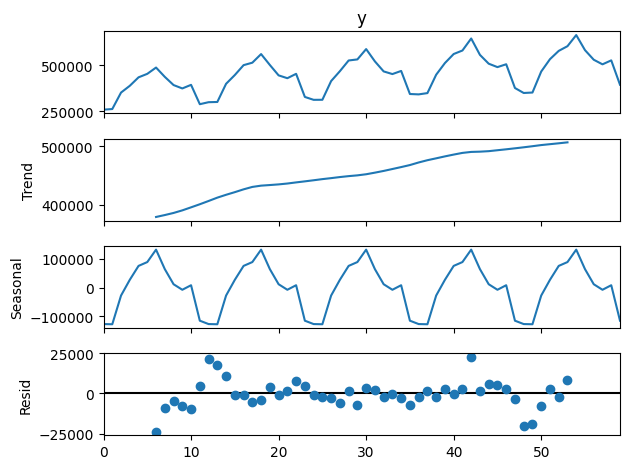

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(monthly_df['y'], model='additive', period=12)
result.plot()
plt.show()


This shows three parts:

Trend = long-term movement upward/downward

Seasonality = repeating yearly patterns

Residual = noise/random effects

In [22]:
# create future month labels
future_dates = pd.date_range(monthly_df['ds'].iloc[-1] + pd.offsets.MonthEnd(), periods=12, freq='M')

forecast_table = pd.DataFrame({
    "Month": future_dates.strftime("%Y-%m"),
    "Forecasted_Sales": forecast_values
})

forecast_table


/tmp/ipython-input-1108908481.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(monthly_df['ds'].iloc[-1] + pd.offsets.MonthEnd(), periods=12, freq='M')


,Month,Forecasted_Sales
60,2018-01,380952.788459
61,2018-02,385836.013997
62,2018-03,421296.767998
63,2018-04,383358.047966
64,2018-05,430395.985964
65,2018-06,446686.289877
66,2018-07,466623.365089
67,2018-08,439308.333248
68,2018-09,461957.307777
69,2018-10,448265.846015
